# Function optimization in SciPy

> "What's new?" is an interesting and broadening eternal question, but one
> which, if pursued exclusively, results only in an endless parade of trivia
> and fashion, the silt of tomorrow. I would like, instead, to be concerned
> with the question "What is best?", a question which cuts deeply rather than
> broadly, a question whose answers tend to move the silt downstream.
>
> — Robert M Pirsig, *Zen and the Art of Motorcycle Maintenance*

When hanging a picture on the wall, it is sometimes difficult to get it
straight.  You make an adjustment, step back, evaluate the picture's
horizontality, and repeat.  This is a process of *optimization*: we're
changing the orientation of the portrait until it satisfies our
demand—that it makes a zero angle with the horizon.

In mathematics, our demand is called a "cost function", and the
orientation of the portrait the "parameter".  In a typical
optimization problem, we vary the parameters until the cost function
is minimized.

Consider, for example, the shifted parabola, $f(x) = (x - 3)^2$.
We'd like to find the value of x that minimizes this cost function. We
know that this function, with parameter $x$, has a minimum at 3,
because we can calculate the derivative, set it to zero, and see that $2 (x - 3) = 0$, i.e. $x = 3$.

But, if this function were much more complicated (for example if the
expression had many terms, multiple points of zero derivative,
contained non-linearities, or was dependent on more variables), using
a hand calculation would become arduous.

You can think of the cost function as representing a landscape, where we
are trying to find the lowest point.  That analogy immediately
highlights one of the hard parts of this problem: if you are standing
in any valley, with mountains surrounding you, how do you know whether
you are in the lowest valley, or whether this valley just seems low because it is
surrounded by particularly tall mountains?  In optimization parlance: how
do you know whether you are trapped in a *local
minimum*?  Most optimization algorithms make some
attempt to address the issue[^line_search].

[^line_search]: Optimization algorithms handle this issue in various
                ways, but two common approaches are line searches and
                trust regions.  With a *line search*, you try to find
                the cost function minimum along a specific dimension,
                and then successively attempt the same along the other
                dimensions.  With *trust regions*, we move our guess
                for the minimum in the direction we expect it to be;
                if we see that we are indeed approaching the minimum
                as expected, we repeat the procedure with increased
                confidence.  If not, we lower our confidence and
                search a wider area.

<img src="../figures/generated/optimization_comparison.png"/>
<!-- caption text="Comparison of optimization pathways taken by different
optimization algorithms on the Rosenbrock function (top). Powell's method
performs a line search along the first dimension before doing gradient descent.
The conjugate gradient (CG) method, on the other hand, performs gradient
descent from the starting point." -->

There are many different optimization algorithms to choose from (see
figure).  You get to choose whether your cost function takes a scalar
or a vector as input (i.e., do you have one or multiple parameters to
optimize?).  There are those that require the cost function gradient
to be given and those that automatically estimate it.  Some only
search for parameters in a given area (*constrained optimization*),
and others examine the entire parameter space.

## Optimization in SciPy: `scipy.optimize`

In the rest of this chapter, we are going to use SciPy's `optimize` module to
align two images. Applications of image alignment, or *registration*, include
panorama stitching, combination of different brain scans, super-resolution
imaging, and, in astronomy, object denoising (noise reduction) through the
combination of multiple exposures.

We start, as usual, by setting up our plotting environment:

In [1]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

Let's start with the simplest version of the problem: we have two
images, one shifted relative to the other.  We wish to recover the
shift that will best align our images.

Our optimization function will "jiggle" one of the images, and see
whether jiggling it in one direction or another reduces their
dissimilarity.  By doing this repeatedly, we can try to find the
correct alignment.

### An example: computing optimal image shift

You'll remember our astronaut — Eileen Collins — from chapter 3.
We will be shifting this image by 50 pixels to the right then comparing it back
to the original until we
find the shift that best matches. Obviously this is a silly thing to do, as we
know the original position, but this way we know the truth, and we can check
how our algorithm is doing. Here's the original and shifted image.

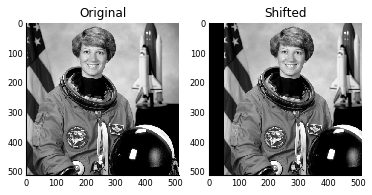

In [2]:
from skimage import data, color
from scipy import ndimage as ndi

astronaut = color.rgb2gray(data.astronaut())
shifted = ndi.shift(astronaut, (0, 50))

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(shifted)
axes[1].set_title('Shifted');

<!-- caption text="Horizontally shifting an image" -->

For the optimization algorithm to do its work, we need some way of
defining "dissimilarity"—i.e., the cost function.  The easiest way to do this is to
simply calculate the average of the squared differences, often called the
*mean squared error*, or MSE.

In [3]:
import numpy as np

def mse(arr1, arr2):
    """Compute the mean squared error between two arrays."""
    return np.mean((arr1 - arr2)**2)

This will return 0 when the images are perfectly aligned, and a higher
value otherwise. With this cost function, we can check whether two images are aligned:

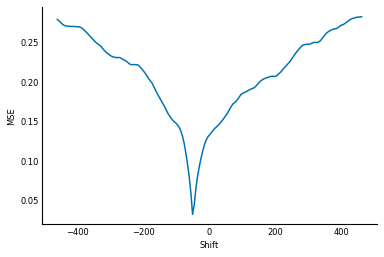

In [4]:
ncol = astronaut.shape[1]

# Cover a distance of 90% of the length in columns,
# with one value per percentage point
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
mse_costs = []

for shift in shifts:
    shifted_back = ndi.shift(shifted, (0, shift))
    mse_costs.append(mse(astronaut, shifted_back))

fig, ax = plt.subplots()
ax.plot(shifts, mse_costs)
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

<!-- caption text="Mean squared error as a function of horizontal shift of the
transformed image" -->

With the cost function defined, we can ask `scipy.optimize.minimize`
to search for optimal parameters:

In [5]:
from scipy import optimize

def astronaut_shift_error(shift, image):
    corrected = ndi.shift(image, (0, shift))
    return mse(astronaut, corrected)

res = optimize.minimize(astronaut_shift_error, 0, args=(shifted,),
                        method='Powell')

print(f'The optimal shift for correction is: {res.x}')

The optimal shift for correction is: -49.99997565757095


It worked! We shifted it by +50 pixels, and, thanks to our MSE measure, SciPy's
`optimize.minimize` function has given us the correct amount of shift (-50) to
get it back to its original state.

It turns out, however, that this was a particularly easy optimization problem,
which brings us to the principal difficulty of this kind of
alignment: sometimes, the MSE has to get worse before it gets better.

Let's look again at shifting images, starting with the unmodified image:

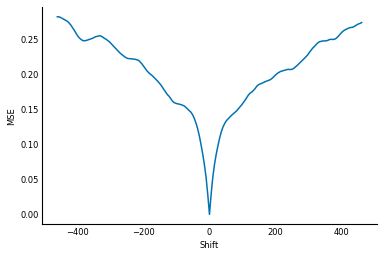

In [6]:
ncol = astronaut.shape[1]

# Cover a distance of 90% of the length in columns,
# with one value per percentage point
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
mse_costs = []

for shift in shifts:
    shifted1 = ndi.shift(astronaut, (0, shift))
    mse_costs.append(mse(astronaut, shifted1))

fig, ax = plt.subplots()
ax.plot(shifts, mse_costs)
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

<!-- caption text="Mean squared error as a function of shift from the original
image" -->

Starting at zero shift, have a look at the MSE value as the shift becomes
increasingly negative: it increases consistently until around -300
pixels of shift, where it starts to decrease again! Only slightly, but it
decreases nonetheless. The MSE bottoms out at around -400, before it
increases again. This is called a *local minimum*.
Because optimization methods only have access to "nearby"
values of the cost function, if the function improves by moving in the "wrong"
direction, the `minimize` process will move that way regardless. So, if we
start by an image shifted by -340 pixels:

In [7]:
shifted2 = ndi.shift(astronaut, (0, -340))

`minimize` will shift it by a further 40 pixels or so,
instead of recovering the original image:

In [8]:
res = optimize.minimize(astronaut_shift_error, 0, args=(shifted2,),
                        method='Powell')

print(f'The optimal shift for correction is {res.x}')

The optimal shift for correction is -38.51778619396494


The common solution to this problem is to smooth or downscale the images, which
has the dual result of smoothing the objective function. Have a look at the
same plot, after having smoothed the images with a Gaussian filter:

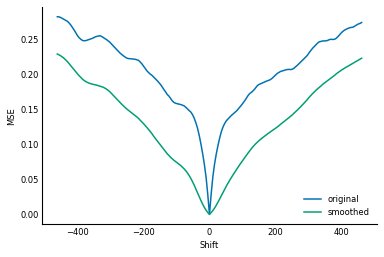

In [9]:
from skimage import filters

astronaut_smooth = filters.gaussian(astronaut, sigma=20)

mse_costs_smooth = []
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
for shift in shifts:
    shifted3 = ndi.shift(astronaut_smooth, (0, shift))
    mse_costs_smooth.append(mse(astronaut_smooth, shifted3))

fig, ax = plt.subplots()
ax.plot(shifts, mse_costs, label='original')
ax.plot(shifts, mse_costs_smooth, label='smoothed')
ax.legend(loc='lower right')
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

<!-- caption text="Effect of smoothing on MSE" -->

As you can see, with some rather extreme smoothing, the "funnel" of
the error function becomes wider, and less bumpy. Rather than smoothing the
function itself we can get a similar effect by blurring the images before
comparing them. Therefore, modern alignment
software uses what's called a *Gaussian pyramid*, which is a set of
progressively lower resolution versions of the same image.  We align
the the lower resolution (blurrier) images first, to get an
approximate alignment, and then progressively refine the alignment
with sharper images.

In [10]:
def downsample2x(image):
    offsets = [((s + 1) % 2) / 2 for s in image.shape]
    slices = [slice(offset, end, 2)
              for offset, end in zip(offsets, image.shape)]
    coords = np.mgrid[slices]
    return ndi.map_coordinates(image, coords, order=1)


def gaussian_pyramid(image, levels=6):
    """Make a Gaussian image pyramid.

    Parameters
    ----------
    image : array of float
        The input image.
    max_layer : int, optional
        The number of levels in the pyramid.

    Returns
    -------
    pyramid : iterator of array of float
        An iterator of Gaussian pyramid levels, starting with the top
        (lowest resolution) level.
    """
    pyramid = [image]

    for level in range(levels - 1):
        blurred = ndi.gaussian_filter(image, sigma=2/3)
        image = downsample2x(image)
        pyramid.append(image)

    return reversed(pyramid)

Let's see how the 1D alignment looks along that pyramid:

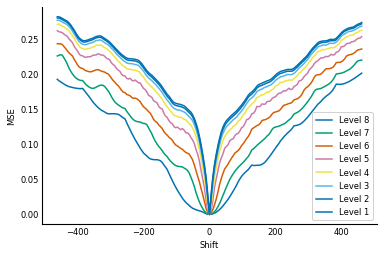

In [11]:
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
nlevels = 8
costs = np.empty((nlevels, len(shifts)), dtype=float)
astronaut_pyramid = list(gaussian_pyramid(astronaut, levels=nlevels))
for col, shift in enumerate(shifts):
    shifted = ndi.shift(astronaut, (0, shift))
    shifted_pyramid = gaussian_pyramid(shifted, levels=nlevels)
    for row, image in enumerate(shifted_pyramid):
        costs[row, col] = mse(astronaut_pyramid[row], image)

fig, ax = plt.subplots()
for level, cost in enumerate(costs):
    ax.plot(shifts, cost, label='Level %d' % (nlevels - level))
ax.legend(loc='lower right', frameon=True, framealpha=0.9)
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

<!-- caption text="Mean squared error of shift at various levels of a Gaussian
pyramid" -->

As you can see, at the highest level of the pyramid, that bump at a shift of
about -325 disappears. We can therefore get an approximate alignment at that
level, then pop down to the lower levels to refine that alignment.

## Image registration with `optimize`

Let's automate that, and try with a "real" alignment, with three parameters:
rotation, translation in the row dimension, and translation in the
column dimension. This is called a "*rigid* registration" because there are no
deformations of any kind (scaling, skew, or other stretching). The object is
considered solid and moved around (including rotation) until a match is found.

To simplify the code, we'll use the scikit-image *transform* module to compute
the shift and rotation of the image. SciPy's `optimize` requires a vector of
parameters as input. We first make a
function that will take such a vector and produce a rigid transformation with
the right parameters:

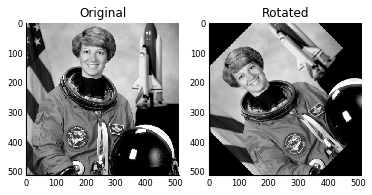

In [12]:
from skimage import transform

def make_rigid_transform(param):
    r, tc, tr = param
    return transform.SimilarityTransform(rotation=r,
                                         translation=(tc, tr))

rotated = transform.rotate(astronaut, 45)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(rotated)
axes[1].set_title('Rotated');

<!-- caption text="Another transformation: rotation" -->

Next, we need a cost function. This is just MSE, but SciPy requires a specific
format: the first argument needs to be the *parameter vector*, which it is
optimizing. Subsequent arguments can be passed through the `args` keyword as a
tuple, but must remain fixed: only the parameter vector can be optimized. In
our case, this is just the rotation angle and the two translation parameters:

In [13]:
def cost_mse(param, reference_image, target_image):
    transformation = make_rigid_transform(param)
    transformed = transform.warp(target_image, transformation, order=3)
    return mse(reference_image, transformed)

Finally, we write our alignment function, which optimizes our cost function
*at each level of the Gaussian pyramid*, using the result of the previous
level as a starting point for the next one:

In [14]:
def align(reference, target, cost=cost_mse):
    nlevels = 7
    pyramid_ref = gaussian_pyramid(reference, levels=nlevels)
    pyramid_tgt = gaussian_pyramid(target, levels=nlevels)

    levels = range(nlevels, 0, -1)
    image_pairs = zip(pyramid_ref, pyramid_tgt)

    p = np.zeros(3)

    for n, (ref, tgt) in zip(levels, image_pairs):
        p[1:] *= 2

        res = optimize.minimize(cost, p, args=(ref, tgt), method='Powell')
        p = res.x

        # print current level, overwriting each time (like a progress bar)
        print(f'Level: {n}, Angle: {np.rad2deg(res.x[0]) :.3}, '
              f'Offset: ({res.x[1] * 2**n :.3}, {res.x[2] * 2**n :.3}), '
              f'Cost: {res.fun :.3}', end='\r')

    print('')  # newline when alignment complete
    return make_rigid_transform(p)

Let's try it with our astronaut image. We rotate it by 60 degrees and add some
noise to it. Can SciPy recover the correct transform?

Level: 1, Angle: -60.0, Offset: (-1.87e+02, 6.98e+02), Cost: 0.0369


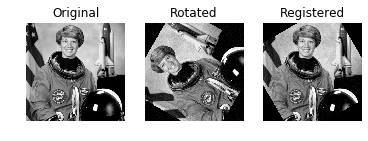

In [15]:
from skimage import util

theta = 60
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated)
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')

<!-- caption text="Optimization used to recover image alignment" -->

We're feeling pretty good now. But our choice of parameters actually masked
the difficulty of optimization: Let's see what happens with a rotation of
50 degrees, which is *closer* to the original image:

Level: 1, Angle: 0.414, Offset: (2.85, 38.4), Cost: 0.14132


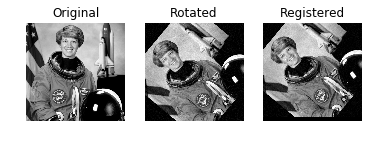

In [16]:
theta = 50
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated)
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')

<!-- caption text="Failed optimization" -->

Even though we started closer to the original image, we failed to
recover the correct rotation. This is because optimization techniques can get
stuck in local minima, little bumps on the road to success, as we saw above
with the shift-only alignment. They can therefore be quite sensitive to the
starting parameters.

## Avoiding local minima with basin hopping

A 1997 algorithm devised by David Wales and Jonathan Doyle [^basinhop], called
*basin-hopping*, attempts to avoid local minima by trying an optimization from
some initial parameters, then moving away from the found local minimum in a
random direction, and optimizing again. By choosing an appropriate step size
for these random moves, the algorithm can avoid falling into the same local
minimum twice, and thus explore a much larger area of the parameter space than
simple gradient-based optimization methods.

We leave it as an exercise to incorporate SciPy's implementation of basin-hopping
into our alignment function. You'll need it for later parts of the chapter, so
feel free to peek at the solution at the end of the book if you're stuck.

[^basinhop]: David J. Wales and Jonathan P.K. Doyle (1997). Global Optimization
             by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones
             Clusters Containing up to 110 Atoms.
             **Journal of Physical Chemistry 101(28):5111–5116**
             DOI: 10.1021/jp970984n

<!-- exercise begin -->

**Exercise:** Try modifying the `align` function to use
`scipy.optimize.basinhopping`, which has explicit strategies to avoid local minima.

*Hint:* limit using basin-hopping to just the top levels of the pyramid, as it is
a slower optimization approach, and could take rather long to run at full image
resolution.

<!-- solution begin -->

**Solution:** We use basin-hopping at the higher levels of the pyramid, but use
Powell's method for the lower levels, because basin-hopping is too
computationally expensive to run at full resolution:

In [17]:
def align(reference, target, cost=cost_mse, nlevels=7, method='Powell'):
    pyramid_ref = gaussian_pyramid(reference, levels=nlevels)
    pyramid_tgt = gaussian_pyramid(target, levels=nlevels)

    levels = range(nlevels, 0, -1)
    image_pairs = zip(pyramid_ref, pyramid_tgt)

    p = np.zeros(3)

    for n, (ref, tgt) in zip(levels, image_pairs):
        p[1:] *= 2
        if method.upper() == 'BH':
            res = optimize.basinhopping(cost, p,
                                        minimizer_kwargs={'args': (ref, tgt)})
            if n <= 4:  # avoid basin-hopping in lower levels
                method = 'Powell'
        else:
            res = optimize.minimize(cost, p, args=(ref, tgt), method='Powell')
        p = res.x
        # print current level, overwriting each time (like a progress bar)
        print(f'Level: {n}, Angle: {np.rad2deg(res.x[0]) :.3}, '
              f'Offset: ({res.x[1] * 2**n :.3}, {res.x[2] * 2**n :.3}), '
              f'Cost: {res.fun :.3}', end='\r')

    print('')  # newline when alignment complete
    return make_rigid_transform(p)

Now let's try that alignment:

Level: 1, Angle: -50.0, Offset: (-2.09e+02, 5.74e+02), Cost: 0.0385


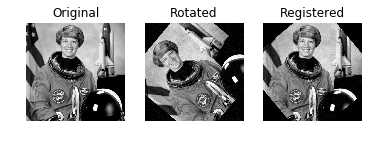

In [18]:
from skimage import util

theta = 50
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated, nlevels=8, method='BH')
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')

<!-- caption text="Image alignment using basin-hopping" -->

Success! Basin-hopping was able to recover the correct alignment, even in the
problematic case in which the `minimize` function got stuck.

<!-- solution end -->

<!-- exercise end -->

## "What is best?": Choosing the right objective function

At this point, we have a working registration approach, which is most
excellent. But it turns out that we've only solved the easiest of registration
problems: aligning images of the same *modality*. This means that we expect
bright pixels in the reference image to match up to bright pixels in the test
image.

We now move on to aligning different color channels of the same image,
where we can no longer rely on the channels having the same modality. This task
has historical significance: between 1909 and 1915, the photographer Sergei
Mikhailovich Prokudin-Gorskii produced color photographs of the Russian empire
before color photography had been invented. He did this by taking three
different monochrome pictures of a scene, each with a different color filter
placed in front of the lens.

Aligning bright pixels together, as the MSE implicitly does, won't work in
this case. Take, for example, these three pictures of a stained glass window
in the Church of Saint John the Theologian, taken from the [Library of Congress
Prokudin-Gorskii Collection](http://www.loc.gov/pictures/item/prk2000000263/):

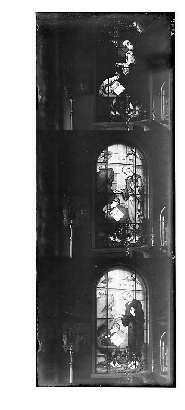

In [19]:
from skimage import io
stained_glass = io.imread('data/00998v.jpg') / 255  # use float image in [0, 1]
fig, ax = plt.subplots(figsize=(4.8, 7))
ax.imshow(stained_glass)
ax.axis('off');

<!-- caption text="A Prokudin-Gorskii plate: three photos of the same stained
glass window, taken with three different filters" -->

Take a look at St John's robes: they look pitch black in one image, gray in
another, and bright white in the third! This would result in a terrible MSE
score, even with perfect alignment.

Let's see what we can do with this. We start by splitting the plate into its
component channels:

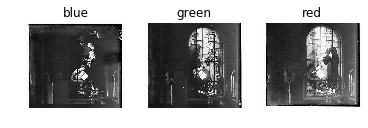

In [20]:
nrows = stained_glass.shape[0]
step = nrows // 3
channels = (stained_glass[:step],
            stained_glass[step:2*step],
            stained_glass[2*step:3*step])
channel_names = ['blue', 'green', 'red']
fig, axes = plt.subplots(1, 3)
for ax, image, name in zip(axes, channels, channel_names):
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(name)

<!-- caption text="Splitting the plate into different channels" -->

First, we overlay all three images to verify that the alignment indeed needs to
be fine-tuned between the three channels:

/Users/squiresrb/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


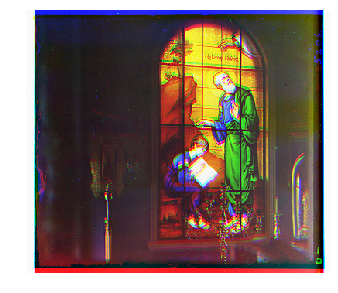

In [21]:
blue, green, red = channels
original = np.dstack((red, green, blue))
fig, ax = plt.subplots(figsize=(4.8, 4.8), tight_layout=True)
ax.imshow(original)
ax.axis('off');

<!-- caption text="Naive overlay of Prokudin-Gorskii channels results in color
halos" -->

You can see by the color "halos" around objects in the image that the colors
are close to alignment, but not quite. Let's try to align them in the same
way that we aligned the astronaut image above, using the MSE. We use one color
channel, green, as the reference image, and align the blue and red channels to
that.

*** Aligning blue to green ***
Level: 1, Angle: -0.0474, Offset: (-0.867, 15.4), Cost: 0.0499
** Aligning red to green ***
Level: 1, Angle: 0.0339, Offset: (-0.269, -8.88), Cost: 0.0311


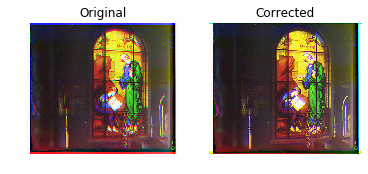

In [22]:
print('*** Aligning blue to green ***')
tf = align(green, blue)
cblue = transform.warp(blue, tf, order=3)

print('** Aligning red to green ***')
tf = align(green, red)
cred = transform.warp(red, tf, order=3)

corrected = np.dstack((cred, green, cblue))
f, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(original)
ax0.set_title('Original')
ax1.imshow(corrected)
ax1.set_title('Corrected')
for ax in (ax0, ax1):
    ax.axis('off')

<!-- caption text="MSE-based alignment reduces but does not eliminate the color
halos" -->

The alignment is a little bit better than with the raw images, because the red
and the green channels are correctly aligned, probably thanks to the giant
yellow patch of sky. However, the blue channel is still off, because the bright
spots of blue don't coincide with the green channel. That means that the MSE
will be lower when the channels are *mis*-aligned so that blue patches overlap
with some bright green spots.

We turn instead to a measure called *normalized mutual information* (NMI),
which measures correlations between the different brightness bands of the
different images. When the images are perfectly aligned, any object of uniform
color will create a large correlation between the shades of the different
component channels, and a correspondingly large NMI value. In a sense, NMI
measures how easy it would be to predict a pixel value of one image given the
value of the corresponding pixel in the other. It was defined in the paper
"Studholme, C., Hill, D.L.G., Hawkes, D.J., *An Overlap Invariant Entropy Measure
of 3D Medical Image Alignment*, Patt. Rec. 32, 71–86 (1999)":

$$I(X, Y) = \frac{H(X) + H(Y)}{H(X, Y)},$$

where $H(X)$ is the *entropy* of $X$, and $H(X, Y)$ is the joint
entropy of $X$ and $Y$. The numerator describes the entropy of the
two images, seen separately, and the denominator the total entropy if
they are observed together. Values can vary between 1 (maximally
aligned) and 2 (minimally aligned)[^mi_calc]. See Chapter 5 for a
more in-depth discussion of entropy.

[^mi_calc]: A quick handwavy explanation is that entropy is calculated
            from the histogram of the quantity under consideration.
            If $X = Y$, then the joint histogram $(X, Y)$ is diagonal,
            and that diagonal is the same as that of either $X$ or
            $Y$.  Thus, $H(X) = H(Y) = H(X, Y)$ and $I(X, Y) = 2$.

In Python code, this becomes:

In [23]:
from scipy.stats import entropy

def normalized_mutual_information(A, B):
    """Compute the normalized mutual information.

    The normalized mutual information is given by:

                H(A) + H(B)
      Y(A, B) = -----------
                  H(A, B)

    where H(X) is the entropy ``- sum(x log x) for x in X``.

    Parameters
    ----------
    A, B : ndarray
        Images to be registered.

    Returns
    -------
    nmi : float
        The normalized mutual information between the two arrays, computed at a
        granularity of 100 bins per axis (10,000 bins total).
    """
    hist, bin_edges = np.histogramdd([np.ravel(A), np.ravel(B)], bins=100)
    hist /= np.sum(hist)

    H_A = entropy(np.sum(hist, axis=0))
    H_B = entropy(np.sum(hist, axis=1))
    H_AB = entropy(np.ravel(hist))

    return (H_A + H_B) / H_AB

Now we define a *cost function* to optimize, as we defined `cost_mse` above:

In [24]:
def cost_nmi(param, reference_image, target_image):
    transformation = make_rigid_transform(param)
    transformed = transform.warp(target_image, transformation, order=3)
    return -normalized_mutual_information(reference_image, transformed)

Finally, we use this with our basinhopping-optimizing aligner:

*** Aligning blue to green ***
Level: 1, Angle: 0.444, Offset: (6.07, 0.354), Cost: -1.0847
** Aligning red to green ***
Level: 1, Angle: 0.000657, Offset: (-0.635, -7.67), Cost: -1.11.13


(-0.5, 393.5, 340.5, -0.5)

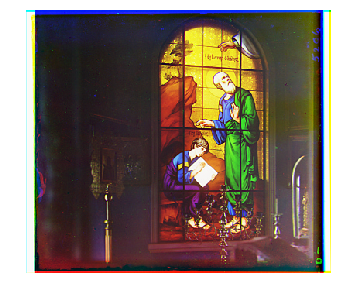

In [25]:
print('*** Aligning blue to green ***')
tf = align(green, blue, cost=cost_nmi)
cblue = transform.warp(blue, tf, order=3)

print('** Aligning red to green ***')
tf = align(green, red, cost=cost_nmi)
cred = transform.warp(red, tf, order=3)

corrected = np.dstack((cred, green, cblue))
fig, ax = plt.subplots(figsize=(4.8, 4.8), tight_layout=True)
ax.imshow(corrected)
ax.axis('off')

<!-- caption text="Prokudin-Gorskii channels aligned with normalized mutual
information" -->

What a glorious image! Realize that this artifact was created before color
photography existed! Notice God's pearly white robes, John's white beard,
and the white pages of the book held by Prochorus, his scribe — all of which
were missing from the MSE-based alignment, but look wonderfully clear using NMI.
Notice also the realistic gold of the candlesticks in the foreground.

We've illustrated the two key concepts in function optimization in this
chapter: understanding local minima and how to avoid them, and choosing the
right function to optimize to achieve a particular objective. Solving these
allows you to apply optimization to a wide array of scientific problems!